In [1]:
from google.cloud import bigquery
from google.oauth2 import service_account

import pandas as pd
import numpy as np
import math
from datetime import datetime,timezone

from scipy import stats


In [2]:
# import functions_framework
# @functions_framework.http
# def load_v2_new_incident_ml_to_bq(request):

isTrainData=False
isExploreMode=True


In [54]:
dt_imported=datetime.now(timezone.utc)

str_imported=dt_imported.strftime('%Y-%m-%d %H:%M:%S')
print(f"Imported DateTime: {str_imported}" )

# explore min and max import data
imported_to='2023-11-01'
# SELECT max(imported_at) as max_date,min(imported_at) as min_date  FROM `pongthorn.SMartDW.incident` ;
# SELECT max(open_datetime) as max_date,min(open_datetime) as min_date  FROM `pongthorn.SMartDW.incident` ;


Imported DateTime: 2023-11-11 20:24:25


In [55]:
schema_for_new_data=None
threshold_x_sd = 3  # 2x-4x
split_test=0.2

In [56]:
# projectId='smart-data-ml'
# credentials = service_account.Credentials.from_service_account_file(r'C:\Windows\smart-data-ml-91b6f6204773.json')
# client = bigquery.Client(credentials=credentials, project=projectId)


projectId='pongthorn'
client = bigquery.Client(project=projectId)

dw_dataset_id="SMartDW"
dataset_id="SMartML"

dw_table_id = f"{projectId}.{dw_dataset_id}.incident"

In [57]:
def load_data_bq(sql:str):

 query_result=client.query(sql)
 df_all=query_result.to_dataframe()
 return df_all

def loadDataFrameToBQ(table_id,dfx):
    try:
        if isTrainData:
            job_config = bigquery.LoadJobConfig(
                write_disposition="WRITE_TRUNCATE",
            )
        else:
                   job_config = bigquery.LoadJobConfig(
                write_disposition="WRITE_APPEND",schema=schema_for_new_data
            )

        job = client.load_table_from_dataframe(
            dfx, table_id, job_config=job_config
        )
        job.result()  # Wait for the job to complete.
        print(f"TrainData={isTrainData} : {len(dfx)} rows imported to {table_id} successfully")

    except BadRequest as e:
        print("Bigquery Error\n")
        for e in job.errors:
            print('ERROR: {}'.format(e['message']))

In [58]:
label='severity_id'
labelName='severity_name'

removeCols=['updated_at','imported_at']

# dateCols=['open_datetime','close_datetime','response_datetime','resolved_datetime']
# numbericCols=['open_to_close_hour','response_to_resolved_hour']
# start_end_list=[ ['open_datetime','close_datetime'],['response_datetime','resolved_datetime']]

dateCols=['open_datetime','close_datetime']
numbericCols=['open_to_close_hour']
start_end_list=[ ['open_datetime','close_datetime']]


rangeCols=[]
cateCols=['sla','product_type','brand','service_type','incident_type']

# Create New Data Table

In [59]:
def get_table_schema(table_ml_id):
    schema=[]
    try:
        table=client.get_table(table_ml_id)  # Make an API request.
        schema=table.schema
        print("Table {} already exists.".format(table_ml_id))
    except Exception as ex:
        schema = [
        bigquery.SchemaField("id", "INTEGER", mode="REQUIRED"),
        bigquery.SchemaField("severity_id", "INTEGER", mode="REQUIRED"),
        bigquery.SchemaField("severity_name", "STRING", mode="REQUIRED"),
        bigquery.SchemaField("sla", "STRING", mode="REQUIRED"),    
        bigquery.SchemaField("product_type", "STRING", mode="REQUIRED"),  
        bigquery.SchemaField("brand", "STRING", mode="REQUIRED"),  
        bigquery.SchemaField("service_type", "STRING", mode="REQUIRED"),  
        bigquery.SchemaField("incident_type", "STRING", mode="REQUIRED"),  
        bigquery.SchemaField("open_to_close_hour", "FLOAT", mode="REQUIRED"),
        bigquery.SchemaField("range_open_to_close_hour", "STRING", mode="REQUIRED"),    
        bigquery.SchemaField("imported_at", "DATETIME", mode="REQUIRED")    
        ]

        table = bigquery.Table(table_ml_id,schema=schema)
        table.time_partitioning = bigquery.TimePartitioning(
        type_=bigquery.TimePartitioningType.DAY,field="imported_at")


        table = client.create_table(table)  # Make an API request.
        print(
            "Created table {}.{}.{}".format(table.project, table.dataset_id, table.table_id)
        )
    finally:
       print(f"Get Schema of {table_ml_id} as below.")    
       return schema
        

# Get Max Import Data From New Data

In [60]:
def get_last_imported_at(table_ml_id):

    sql_lastImport=f"SELECT max(imported_at) as last_imported from `{table_ml_id}` "

    print(sql_lastImport)

    job_lastImported=client.query(sql_lastImport)
    str_lastImported=None
    for row in job_lastImported:    
        if row.last_imported is not None: 
            str_lastImported=row.last_imported.strftime('%Y-%m-%d %H:%M:%S')
    print(f"Last Imported DateTime: {str_lastImported}" )

    if str_lastImported is not None:
      print("Start date from last loading")  
      start_date_query=str_lastImported
    else:
      start_date_query=imported_to  
      print("Init First loading") 
    return start_date_query    
    

# Explore and Transform Data

In [61]:
sql_all=f"""
SELECT  id,severity_id,severity_name
,sla,product_type,brand,service_type,incident_type
,open_datetime,  close_datetime
,updated_at,imported_at
FROM `{dw_table_id}` """

if isTrainData: # get from imported_to specified by you
    print(f"Build train/test data during imported date < {datetime.strptime(imported_to,'%Y-%m-%d')}")

    train_name='train2_incident'
    test_name='test2_incident'
    train_table_id=f"{projectId}.{dataset_id}.{train_name}"
    test_tabel_id=f"{projectId}.{dataset_id}.{test_name}"
    print(f"TrainTable2={train_table_id} and TestTable2={test_tabel_id}")
    
    sql_all=f""" {sql_all}
    WHERE imported_at< '{imported_to}'
    order by imported_at desc
    
    """
    
else: # get from max update
    new_incident_name='new2_incident'    
    new_incident_table_id=f"{projectId}.{dataset_id}.{new_incident_name}"
    print(f"{new_incident_table_id}")
    
    # 1.get table and its schema
    schema_for_new_data=get_table_schema(new_incident_table_id)
    # print(schema_for_new_data)
    imported_to=get_last_imported_at(new_incident_table_id)  # get  start_date_query  from this method
    print(f"Load the most up-to-date new data from imported date >= {imported_to}")
    print(imported_to)
    
    
    sql_all=f""" {sql_all}
    WHERE imported_at>= '{imported_to}'
    order by imported_at desc
    
    """

print(sql_all)


pongthorn.SMartML.new2_incident
Created table pongthorn.SMartML.new2_incident
Get Schema of pongthorn.SMartML.new2_incident as below.
SELECT max(imported_at) as last_imported from `pongthorn.SMartML.new2_incident` 
Last Imported DateTime: None
Init First loading
Load the most up-to-date new data from imported date >= 2023-11-01
2023-11-01
 
SELECT  id,severity_id,severity_name
,sla,product_type,brand,service_type,incident_type
,open_datetime,  close_datetime
,updated_at,imported_at
FROM `pongthorn.SMartDW.incident` 
    WHERE imported_at>= '2023-11-01'
    order by imported_at desc
    
    


In [62]:
print("Load data from Bigquery")
df_all=load_data_bq(sql_all)
no_original_rows=len(df_all)

if no_original_rows==0:
 print("No records from bigquery")  
 quit()
 # return "No new data imported to bigquery"   
else:
 df_all=df_all.drop_duplicates(subset=['id'],keep='last')   
 print(f"Import at :{df_all['imported_at'].min()} - {df_all['imported_at'].max()}")
 print(f"Open Date : {df_all['open_datetime'].min()} - {df_all['open_datetime'].max()}")   
 print(df_all.shape)  
print(df_all.info())
print(df_all[["severity_id","severity_name","updated_at","imported_at"]].tail())

Load data from Bigquery
Import at :2023-11-01 17:05:07.085267 - 2023-11-11 17:05:06.147475
Open Date : 2023-08-02 13:34:00 - 2023-11-10 13:10:00
(67, 12)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 67 entries, 0 to 67
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   id              67 non-null     Int64         
 1   severity_id     67 non-null     Int64         
 2   severity_name   67 non-null     object        
 3   sla             67 non-null     object        
 4   product_type    67 non-null     object        
 5   brand           67 non-null     object        
 6   service_type    67 non-null     object        
 7   incident_type   67 non-null     object        
 8   open_datetime   67 non-null     datetime64[ns]
 9   close_datetime  67 non-null     datetime64[ns]
 10  updated_at      67 non-null     datetime64[ns]
 11  imported_at     67 non-null     datetime64[ns]
dtypes: Int64(2

# Transform and enrich data

# Manage Numberic Cols
### 1-Find Time Inverval
### 2-Remove outlier on Time Interval to service
### 3-Find any rows  contain zero time period
### 4-Create range from time-interval (best,good,moderate,bad,worst)

# Bining Range

function is used to separate the array elements into many different ranges . 
The cut function is mainly used to perform statistical analysis on scalar data. 

we can convert hour to range   
* (0, 24] =by 1 day =best
* (24, 168] =  1day -1 week  =good
* (168, 360]=  1week- 15 days(half a month) =fair
* (360, 720]= 15 dasy-1 month =bad
* (720, 2349]=1 month-1 Q =worst

open_to_close_hour ,response_to_resolved_hour , Mostly  we can complate by 1 day (0, 24]
there are few cases that take long to close incident (360, 720]   15 day to  1month

In [63]:
print("Manage Numberic Cols")
listDiffDateDeltaCols=[]
listDiffHourCols=[]
for item  in  start_end_list:
   diff_str=f"{item[0]}_to_{item[1]}" 
   diff_str=diff_str.replace('_datetime','')  
   listDiffDateDeltaCols.append(diff_str)
   df_all[diff_str]=df_all[item[1]]-df_all[item[0]]
    
   diff_hour=f'{diff_str}_hour'
   listDiffHourCols.append(diff_hour)
   df_all[diff_hour] = df_all[diff_str].apply(lambda x:  x.total_seconds() / (60*60) if x is not np.nan else np.nan  )


# https://www.geeksforgeeks.org/z-score-for-outlier-detection-python/
xScoreDiffHourCols=[]
for col in listDiffHourCols:
  z_col=f"zscore_{col}"   
  df_all[z_col] = np.abs(stats.zscore(df_all[col]))   
  xScoreDiffHourCols.append(z_col)  

# df_all.tail()

Manage Numberic Cols


# Remove oulier  and delete zero hour training data

In [64]:
if isTrainData :
    print("Remove oulier  and delete zero hour training data")
    for col in  xScoreDiffHourCols:
      df_all=df_all.query(f"{col}<@threshold_x_sd")


    allRows=df_all.shape[0]
    for col in numbericCols:
        zeroRows=len(df_all.query(f"{col}==0"))
        pctZeroHour=round(zeroRows/allRows*100,1)
        print(f"No. 0-hour row on {col} = {zeroRows}({pctZeroHour} %)")
        df_all=df_all.query(f'{col}!=0')

# Apply Service Level

In [65]:
def service_hour_range(x_hour):
    if x_hour>0 and x_hour<=24:
      return "soonest"
    elif x_hour>25 and x_hour<=168:
      return "soon"
    elif x_hour>168 and x_hour<=360:
      return "fair"
    elif x_hour>360 and x_hour<=720:
      return "late"
    else:
      return "latest"

for col in numbericCols:
    range_col=f"range_{col}"
    rangeCols.append(range_col)
    df_all[range_col]=df_all[col].apply(service_hour_range)

# Final TRansform

In [66]:
removeCols=removeCols+dateCols+xScoreDiffHourCols+listDiffDateDeltaCols
print(f"Remove {removeCols}")
df_all=df_all.drop(columns=removeCols)
no_rows_after_removing_outlier=len(df_all)
pct_row_decrease=round( (no_original_rows-no_rows_after_removing_outlier)/no_original_rows*100 ,0)

print(f"% remove data {pct_row_decrease}")

df_all[['id','severity_id']] =df_all[['id','severity_id']].astype('int64')

if isTrainData==False:
    df_all['imported_at']=dt_imported

print(df_all.info())


print(f"pct removed data ={(no_original_rows-len(df_all))/no_original_rows*100}")
#it is pretty close to 5%   , at most 10% is removable
# df_all[listDiffHourCols].describe(percentiles=[.95,.75,.50,.25,.05]).drop(index=['count','std'])

df_all.tail(30)

Remove ['updated_at', 'imported_at', 'open_datetime', 'close_datetime', 'zscore_open_to_close_hour', 'open_to_close']
% remove data 1.0
<class 'pandas.core.frame.DataFrame'>
Int64Index: 67 entries, 0 to 67
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype              
---  ------                    --------------  -----              
 0   id                        67 non-null     int64              
 1   severity_id               67 non-null     int64              
 2   severity_name             67 non-null     object             
 3   sla                       67 non-null     object             
 4   product_type              67 non-null     object             
 5   brand                     67 non-null     object             
 6   service_type              67 non-null     object             
 7   incident_type             67 non-null     object             
 8   open_to_close_hour        67 non-null     float64            
 9   range_open_to_close

,id,severity_id,severity_name,sla,product_type,brand,service_type,incident_type,open_to_close_hour,range_open_to_close_hour,imported_at
38,3460,2,Major,24x7 4Hrs Resolution Time,Software,HPE,Incident,General Incident,1394.766667,latest,2023-11-11 20:24:25.139247+00:00
39,3916,2,Major,24x7 4Hrs Resolution Time,Server,HPE,Incident,Hard Disk Drive Failure,5.750000,soonest,2023-11-11 20:24:25.139247+00:00
40,3917,2,Major,24x7 4Hrs Resolution Time,Server,HPE,Incident,Hard Disk Drive Failure,5.750000,soonest,2023-11-11 20:24:25.139247+00:00
41,3918,2,Major,24x7 4Hrs Resolution Time,Software,VMWare,Request,Upgrade Software,134.383333,soon,2023-11-11 20:24:25.139247+00:00
42,3910,3,Minor,24x7 6Hrs Resolution Time,Software,CIMCO-CMMS,Incident,Software,6.683333,soonest,2023-11-11 20:24:25.139247+00:00
43,3914,3,Minor,24x7 4Hrs Response Time,Storage,NetApp,Incident,Hard Disk Drive Failure,35.000000,soon,2023-11-11 20:24:25.139247+00:00
44,3915,3,Minor,24x7 4Hrs Response Time,Storage,NetApp,Incident,Hard Disk Drive Failure,7.633333,soonest,2023-11-11 20:24:25.139247+00:00
45,3912,4,Cosmetic,24x7 4Hrs Response Time,Software,Red Hat,Request,General Incident,2.100000,soonest,2023-11-11 20:24:25.139247+00:00
46,3909,4,Cosmetic,8x5 4Hrs Response Time,Switch,HPE,Incident,General Incident,3.650000,soonest,2023-11-11 20:24:25.139247+00:00
47,3908,4,Cosmetic,8x5 4Hrs Response Time,Access Point,HPE,Incident,General Incident,3.650000,soonest,2023-11-11 20:24:25.139247+00:00


In [67]:
# # https://www.geeksforgeeks.org/pandas-cut-method-in-python/
# def explore_ranges_numberic_val(col,rangeList):
#     print(col)
#     rangeList.sort()
#     return pd.cut(df_all[col],rangeList, right=True).value_counts()
# range1= [0,24, 168, 360, 720,math.floor(df_all['open_to_close_hour'].max())]
# print(explore_ranges_numberic_val('open_to_close_hour',range1))
# print("=======================================================")

# range2= [0,24, 168, 360, 720,math.floor(df_all['response_to_resolved_hour'].max())]
# print(explore_ranges_numberic_val('response_to_resolved_hour',range2))
# print("=======================================================")



# Plot Numeric  and Category columns

Plot Numeric  and Category columns


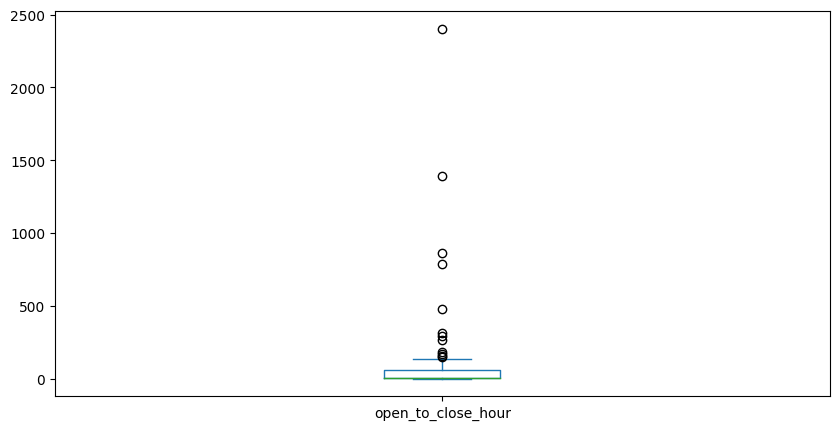

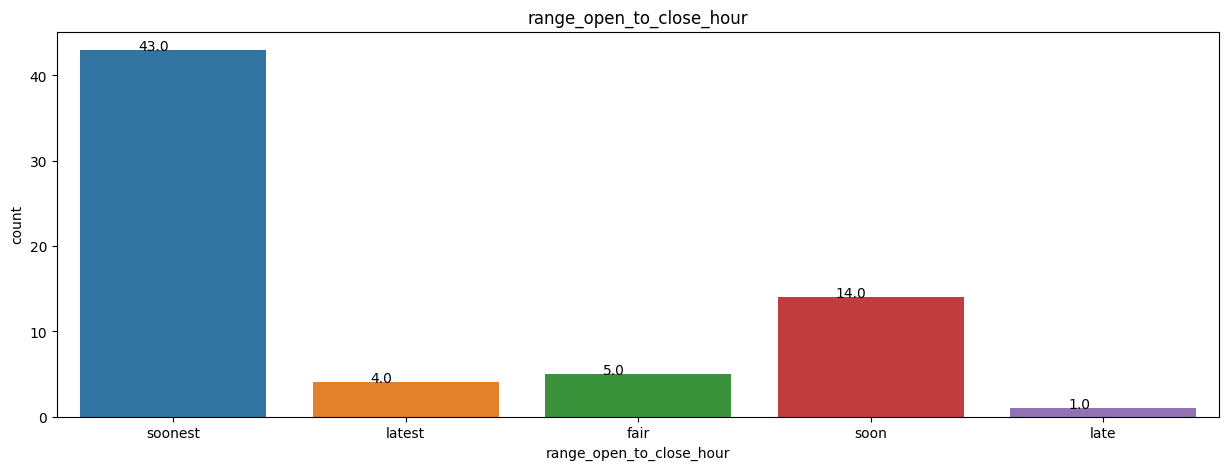

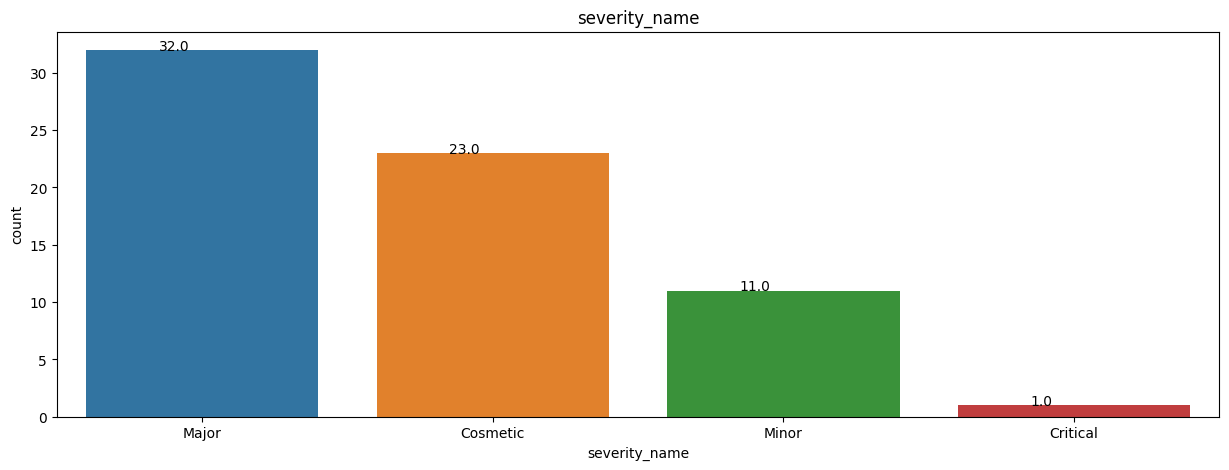

In [68]:
# comment on google cloud
if isExploreMode:
    print("Plot Numeric  and Category columns")
    import seaborn as sns
    import matplotlib.pyplot  as plt

if isExploreMode:
    df_all[numbericCols].plot(kind='box',subplots=True,layout=(1,len(numbericCols)),sharex=False, sharey=False,figsize=(10,5))
    plt.show()
    
if isExploreMode:
    barCols=rangeCols+["severity_name"]
    for col in barCols:
        fig , ax = plt.subplots(figsize=(15,5))
        ax =sns.countplot(x=col, data=df_all,)
        for p in ax.patches:
           ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.25, p.get_height()+0.01))
        plt.title(col)
        plt.show()

# Build Label and Split into Train/Test DataSet

In [69]:
if isTrainData:
    
    print(" Build Label and Split into Train/Test DataSet")
    from sklearn.model_selection import train_test_split
    
    # create label
    map_severity_to_class={4:0,3: 1, 2: 2, 1: 3}
    print(f"Map severity id to LabelCode: {str(map_severity_to_class)}")

    df_all['label_multi_severity'] =df_all['severity_id'].map(map_severity_to_class) 
    def map_4to2_serverity(severity_id):
        if severity_id==1 or severity_id==2:
           return 1
        else:
           return 0 
    df_all['label_binary_severity'] =df_all['severity_id'].apply(map_4to2_serverity)

    print( list(df_all['label_multi_severity'].unique()))
    print(df_all['label_binary_severity'].unique())

    #Split data into 2 dataset to BQ
    len_all=len(df_all)
    print(f"All Data = {len_all}")

    # Split the 80% of total as train
    # The remaining  will be splited equally 50% for valuation and the rest of later part is test

    train, test = train_test_split(df_all,test_size=split_test,random_state=1000,shuffle=True)

    len_all=len(df_all)
    len_train=len(train)

    len_test=len(test)
    print(f'{len_train} =train examples ({round(len_train/len_all*100,1)}%)')
    print(f'{len_test} =test examples ({round(len_test/len_all*100,1)}%)')

    print(train.tail())

    loadDataFrameToBQ(train_table_id,train)
    loadDataFrameToBQ(test_tabel_id,test)  
    
    # if isExploreMode:
    #     train.to_csv(f"data/{train_name}.csv",index=False)
    #     test.to_csv(f"data/{test_name}.csv",index=False)
        
else:
    print(" Build Unseen DataSet")
    
    loadDataFrameToBQ(new_incident_table_id,df_all)
    

 Build Unseen DataSet
TrainData=False : 67 rows imported to pongthorn.SMartML.new2_incident successfully


In [ ]:
# return "Imported data to bigquery successfully"